<b><font size="5">Predicting the Difficulty and Fun of Hiking Trails</font></b>

Here, I build a model to predict the difficulty and fun of backpacking trails I am personally interested in hiking. Thanks to Jane (https://www.kaggle.com/datasets/planejane/national-park-trails) for the base dataset of ~3000 trails in USA national parks. This data was scraped from AllTrails. Attempts to scrape AllTrails data myself were blocked by bot-detection.

Jane's dataset includes columns for trail length, elevation gain, region, state/province, country, route type, latitude, longitude, number of reviews, difficulty, and fun. After some manipulation of the dataset, I add columns for whether the trails include a forest, lake, river, waterfall, beach, historic site, cave, hot spring, and/or backpacking trail. In addition to this dataset, I include data from trails I've hiked myself. I add a column to keep track of which trails are mine, which helps fine-tune the model to my preferences.

Summary of Steps:
1. Format and combine my dataset with the Jane's dataset
1. Analyze and visualize data
1. Generate difficulty model and predictions
1. Generate fun model and predictions
1. Visualize prediction results in a single plot

Summary of Results:
- Difficulty Model Score: 0.705
- Fun Model Score: 0.189

Turns out that a trail's length, elevation gain, location, and physical features are enough to predict its difficulty with decent accuracy. Fun is a different matter. Fun is impacted greatly by season, weather, preparedness, and who you are hiking with, none of which is accounted for.

<b><font size="3">--- Dataset Set Up ---</font></b>

In [1]:
### Imports

import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt, ticker as mticker
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import pandas as pd
import seaborn as sns
import pickle
from sklearn.linear_model import Ridge, Lasso, RidgeCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import plotly.graph_objs as go

In [2]:
### Defining Variables

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
difficultyColors = np.array(['limegreen', 'yellow', 'darkorange', 'red'])
backgroundColor = '#444444'
distColor = 'darkorange'
gainColor = 'deepskyblue'
daysColor = 'violet'
hikesColor = 'tab:red'
legendColor = 'w'
diffModelFileName = 'trailGenie_difficulty.sav'
ratingModelFileName = 'trailGenie_rating.sav'
titleSize = 36
axisLabelSize = 27
tickLabelSize = 18
legendTextSize = 18
standardCanvasHeight = 10
standardCanvasWidth = 20
cvGrid = {"n_estimators": [100, 250, 500],
          "max_depth": [5, 10, 20],
          "min_samples_split": [2, 4, 8],
          "min_samples_leaf": [1, 2, 4]}

In [3]:
### Creating Dataframes

# Grabbing my data
myTrails = pd.read_csv('MyTrails.csv')

myCompletedTrails = myTrails[pd.isna(myTrails.rating) == False]
myWatchedTrails = myTrails[pd.isna(myTrails.rating) == True]

myTrailsForModel = myTrails.drop(['#','days','rain','people','year','month'], axis=1) # I don't have this data from AllTrails
myTrailsForModel['backpacking'] = 1 # All of my data is for backpacking trails
myTrailsForModel['is_jamie'] = 1 # To inform the model which trails are mine
myTrailsForModel['num_reviews'] = 1 # I'm the only one that rates my hikes

myCompletedTrailsForModel = myTrailsForModel[pd.isna(myTrailsForModel.rating) == False]
myWatchedTrailsForModel = myTrailsForModel[pd.isna(myTrailsForModel.rating) == True]

# Grabbing USA national park data (from AllTrails)
usaTrails = pd.read_csv('AllTrailsUsaNationalParks.csv', engine='python')

# Breaking apart concated columns
usaTrails['lat'] = usaTrails.apply(lambda row: row._geoloc.split(': ', 2)[1][:-7], axis=1)
usaTrails['lng'] = usaTrails.apply(lambda row: row._geoloc.split(': ', 2)[2][:-1], axis=1)
usaTrails['forest'] = usaTrails.apply(lambda row: int('forest' in row.features), axis=1)
usaTrails['lake'] = usaTrails.apply(lambda row: int('lake' in row.features), axis=1)
usaTrails['river'] = usaTrails.apply(lambda row: int('river' in row.features), axis=1)
usaTrails['waterfall'] = usaTrails.apply(lambda row: int('waterfall' in row.features), axis=1)
usaTrails['beach'] = usaTrails.apply(lambda row: int('beach' in row.features), axis=1)
usaTrails['historic_site'] = usaTrails.apply(lambda row: int('historic-site' in row.features), axis=1)
usaTrails['cave'] = usaTrails.apply(lambda row: int('cave' in row.features), axis=1)
usaTrails['hot_spring'] = usaTrails.apply(lambda row: int('hot-springs' in row.features), axis=1)
usaTrails['backpacking'] = usaTrails.apply(lambda row: int('backpacking' in row.activities), axis=1)

# Removing "driving" trails, whatever that means
usaTrails['driving'] = usaTrails.apply(lambda row: int('driving' in row.activities), axis=1)
usaTrails = usaTrails[usaTrails.driving == 0]

# Removing useless cols
usaTrails = usaTrails.drop(['trail_id','city_name','popularity','visitor_usage','units',
                            '_geoloc','features','activities','driving'],axis=1)

usaTrails['length'] = usaTrails['length'].apply(lambda row: row/1000) # m to km
usaTrails['is_jamie'] = 0

# Renaming cols
usaTrails = usaTrails.rename(columns={'length': 'len',
                                      'elevation_gain': 'gain',
                                      'difficulty_rating':'difficulty',
                                      'avg_rating':'rating',
                                      'area_name':'park',
                                      'state_name':'province',
                                      'country_name':'country'})

# Sorting cols
usaTrails = usaTrails[['name','len','gain','park','province','country','route_type','lat','lng','forest','lake',
                       'river','waterfall','beach','historic_site','cave','hot_spring','backpacking','is_jamie',
                       'num_reviews','difficulty','rating']]

# Removing outliers (paddling trails, short walks to a lookout, etc...)
usaTrails = usaTrails[usaTrails.gain >= 10]
usaTrails = usaTrails[usaTrails.len >= 0.5]
usaTrails = usaTrails[usaTrails.num_reviews > 0]

# Combining my data with AllTrails data
ourTrails = pd.concat([usaTrails, myCompletedTrailsForModel])
allOurTrails = pd.concat([usaTrails, myTrailsForModel])

# Catagorical col encoding
one_hot = OneHotEncoder(categories=[allOurTrails.route_type.unique(),
                                    allOurTrails.park.unique(),
                                    allOurTrails.province.unique(),
                                    allOurTrails.country.unique()])
transformer = ColumnTransformer([('one_hot', one_hot, ['route_type','park','province','country'])],
                                remainder='passthrough')

<b><font size="3">--- Analysis of Dataset ---</font></b>

In [4]:
### Quick stats

print("FULL DATASET STATS")
print("\n")

print("TOTALS")
print(f"Number of Trails: {ourTrails.shape[0]}")
print('\n')

print("TRAIL AVERAGES")
print(f"Average Distance: {round(ourTrails.len.mean(), 1)} km")
print(f"Average Elevation Gain: {round(ourTrails.gain.mean())} m")
print(f"Backpacking Trail Rate: {round(ourTrails.backpacking.mean(), 2)}")
print(f"Jamie Trail Rate: {round(ourTrails.is_jamie.mean(), 3)}")
print("------------------------------------------------------------")
print("\n")

print("JAMIE TRAIL STATS")
print("\n")

print("TOTALS")
totalDist = myCompletedTrails.len.sum()
print(f"Total Distance: {round(totalDist, 0)} km ({round(totalDist/40075, 3)} Earths, {round(totalDist/42.195, 1)} marathons, {round(totalDist/0.0299)} blue whales)")
totalGain = myCompletedTrails.gain.sum()
print(f"Total Elevation Gain: {totalGain} m ({round(totalGain/(8849-2840), 2)} Everests, {round(totalGain/830, 1)} Burj Khalifas, {round(totalGain/1.8415)} Jamies)")
print(f"Total Number of Trails: {myCompletedTrails.shape[0]}")
print(f"Total Number of Days: {round(myCompletedTrails.days.sum())}")
print("\n")

print("TRAIL RECORDS")
print(f"Most Distance: {round(myCompletedTrails.len.max(), 1)} km")
print(f"Most Elevation Gain: {round(myCompletedTrails.gain.max())} m")
print(f"Greatest Number of Days: {round(myCompletedTrails.days.max())} days")
print(f"Most Distance per Day: {round((myCompletedTrails.len/myCompletedTrails.days).max(), 1)} km/day")
print(f"Most Elevation Gain per Day: {round((myCompletedTrails.gain/myCompletedTrails.days).max())} m/day")
print(f"Most Common Park: {myCompletedTrails.park.mode().iloc[0]} ({round(myCompletedTrails.park.value_counts()[0]/myCompletedTrails.shape[0], 2)} of trails)") 
print("\n")

print("TRAIL AVERAGES")
print(f"Average Distance: {round(myCompletedTrails.len.mean(), 1)} km")
print(f"Average Elevation Gain: {round(myCompletedTrails.gain.mean())} m")
print(f"Average Number of Days: {round(myCompletedTrails.days.mean(), 1)} days")
print(f"Solo Trip Rate: {round(myCompletedTrails[myCompletedTrails.people == 1].shape[0]/myCompletedTrails.shape[0], 2)}")
print("\n")

print("DAY AVERAGES")
print(f"Average Distance: {round((myCompletedTrails.len.sum()/myCompletedTrails.days.sum()), 1)} km")
print(f"Average Elevation Gain: {round(myCompletedTrails.gain.sum()/myCompletedTrails.days.sum())} m")
print(f"Rain Rate: {round(myCompletedTrails.rain.sum()/myCompletedTrails.days.sum(), 2)}")


FULL DATASET STATS


TOTALS
Number of Trails: 2912


TRAIL AVERAGES
Average Distance: 16.0 km
Average Elevation Gain: 638 m
Backpacking Trail Rate: 0.28
Jamie Trail Rate: 0.006
------------------------------------------------------------


JAMIE TRAIL STATS


TOTALS
Total Distance: 482.0 km (0.012 Earths, 11.4 marathons, 16127 blue whales)
Total Elevation Gain: 8430 m (1.4 Everests, 10.2 Burj Khalifas, 4578 Jamies)
Total Number of Trails: 18
Total Number of Days: 45


TRAIL RECORDS
Most Distance: 55.1 km
Most Elevation Gain: 1700 m
Greatest Number of Days: 4 days
Most Distance per Day: 18.4 km/day
Most Elevation Gain per Day: 725 m/day
Most Common Park: Algonquin (0.33 of trails)


TRAIL AVERAGES
Average Distance: 26.8 km
Average Elevation Gain: 468 m
Average Number of Days: 2.5 days
Solo Trip Rate: 0.5


DAY AVERAGES
Average Distance: 10.7 km
Average Elevation Gain: 187 m
Rain Rate: 0.24


In [5]:
### Full Stats

ourTrails.describe()

,len,gain,forest,lake,river,waterfall,beach,historic_site,cave,hot_spring,backpacking,is_jamie,num_reviews,difficulty,rating
count,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000
mean,16.046715,637.645104,0.642857,0.264080,0.300481,0.182692,0.040865,0.026442,0.022665,0.026099,0.280563,0.006181,75.902473,3.309753,4.342205
std,19.737393,856.413382,0.479240,0.440918,0.458546,0.386480,0.198012,0.160474,0.148858,0.159457,0.449352,0.078391,194.142702,1.680470,0.528229
min,0.643736,10.972800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,4.828020,136.855200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,3.000000,4.000000
50%,10.621644,372.922800,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,3.000000,4.500000
75%,20.116750,829.741800,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,63.000000,5.000000,4.500000
max,326.856954,14029.944000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3903.000000,7.000000,5.000000


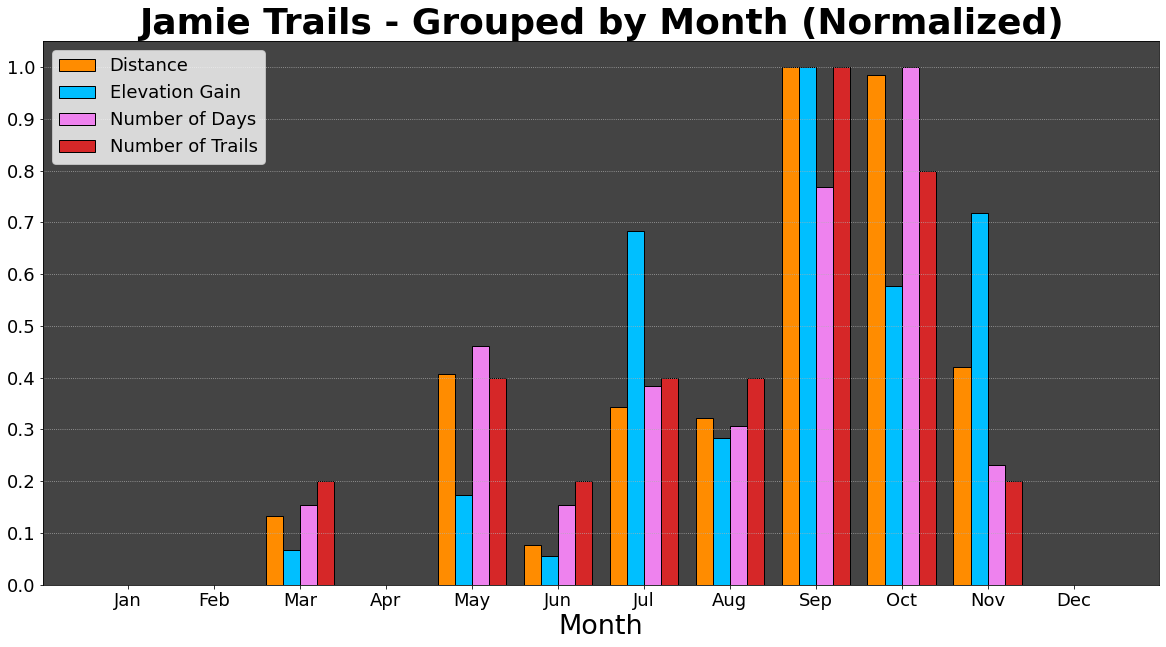

<Figure size 432x288 with 0 Axes>

In [7]:
### Jamie Trails - Grouped by Month

# To be filled one hike at a time
monthDists = np.zeros(12)
monthGains = np.zeros(12)
monthDays = np.zeros(12)
monthHikes = np.zeros(12)

def addHikeToMonth(i, hike):
    monthDists[i] += hike.len
    monthGains[i] += hike.gain
    monthDays[i] += hike.days
    monthHikes[i] += 1

for i, hike in myCompletedTrails.iterrows():
    monthOfHike = str(hike.month)
    if monthOfHike == months[0]:
        addHikeToMonth(0, hike)
    elif monthOfHike == months[1]:
        addHikeToMonth(1, hike)
    elif monthOfHike == months[2]:
        addHikeToMonth(2, hike)
    elif monthOfHike == months[3]:
        addHikeToMonth(3, hike)
    elif monthOfHike == months[4]:
        addHikeToMonth(4, hike)
    elif monthOfHike == months[5]:
        addHikeToMonth(5, hike)
    elif monthOfHike == months[6]:
        addHikeToMonth(6, hike)
    elif monthOfHike == months[7]:
        addHikeToMonth(7, hike)
    elif monthOfHike == months[8]:
        addHikeToMonth(8, hike)
    elif monthOfHike == months[9]:
        addHikeToMonth(9, hike)
    elif monthOfHike == months[10]:
        addHikeToMonth(10, hike)
    elif monthOfHike == months[11]:
        addHikeToMonth(11, hike)
        
# Normalizing
monthDists = monthDists/np.max(monthDists)
monthGains = monthGains/np.max(monthGains)
monthDays = monthDays/np.max(monthDays)
monthHikes = monthHikes/np.max(monthHikes)

# Plotting
ax = plt.gca()
fig = plt.gcf()
ax.set_title("Jamie Trails - Grouped by Month (Normalized)", size=titleSize, fontweight='bold')
xAxis = np.arange(len(months))
plt.bar(xAxis-0.3, monthDists, 0.2, label="Distance", color=distColor, edgecolor='k')
plt.bar(xAxis-0.1, monthGains, 0.2, label="Elevation Gain", color=gainColor, edgecolor='k')
plt.bar(xAxis+0.1, monthDays, 0.2, label="Number of Days", color=daysColor, edgecolor='k')
plt.bar(xAxis+0.3, monthHikes, 0.2, label="Number of Trails", color=hikesColor, edgecolor='k')
plt.legend(loc=2, facecolor=legendColor, prop={'size': legendTextSize})
fig.set_size_inches(standardCanvasWidth, standardCanvasHeight)
plt.xlabel("Month", size=axisLabelSize)
plt.rcParams['axes.facecolor'] = backgroundColor
plt.xticks(xAxis, months)
ax.tick_params(axis='y', which='both', labelsize=tickLabelSize)
ax.tick_params(axis='x', which='both', labelsize=tickLabelSize)
plt.locator_params(axis='y', nbins=11)
plt.grid(axis='y', which='both', linestyle= 'dotted')
plt.grid(axis='x', which='both', linestyle= 'none')
plt.show()
plt.clf()

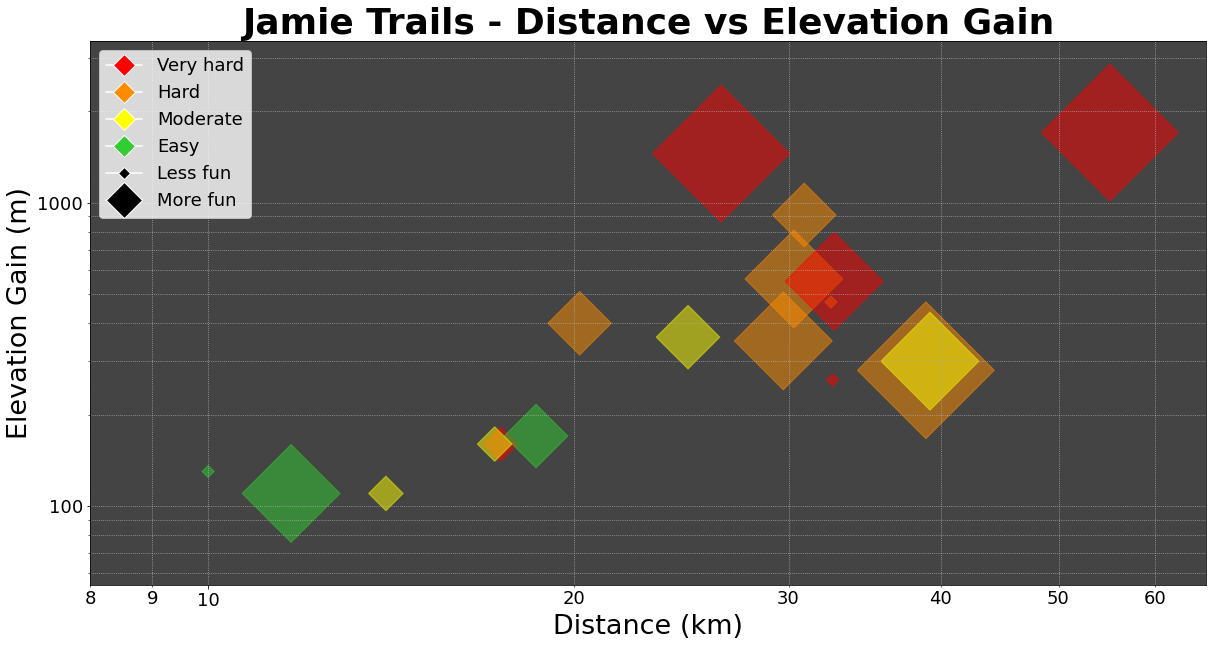

<Figure size 432x288 with 0 Axes>

In [9]:
### Jamie Trails - Distance vs Elevation Gain (with Difficulty, and Rating)
        
def distGainPlot(title, dist, gain, rating, difficulty):
    fig = plt.gcf()
    ax = plt.gca()
    ax.set_title(title, size=titleSize, fontweight="bold")
    legend_elements = [
        Line2D([0], [0], marker='D', color=legendColor, label="Very hard", markerfacecolor=difficultyColors[3], markersize=15),
        Line2D([0], [0], marker='D', color=legendColor, label="Hard", markerfacecolor=difficultyColors[2], markersize=15),
        Line2D([0], [0], marker='D', color=legendColor, label="Moderate", markerfacecolor=difficultyColors[1], markersize=15),
        Line2D([0], [0], marker='D', color=legendColor, label="Easy", markerfacecolor=difficultyColors[0], markersize=15),
        Line2D([0], [0], marker='D', color=legendColor, label="Less fun", markerfacecolor='k', markersize=8),
        Line2D([0], [0], marker='D', color=legendColor, label="More fun", markerfacecolor='k', markersize=25)]
    ax.legend(handles=legend_elements, facecolor=legendColor, prop={'size': legendTextSize}, loc=2)
    plt.scatter(dist, gain, s=rating, c=difficultyColors[difficulty], marker='D', alpha=0.5)
    fig.set_size_inches(standardCanvasWidth, standardCanvasHeight)
    plt.rcParams['axes.facecolor'] = backgroundColor
    ax.set_ylim(min(gain)*0.5, max(gain)*2)
    ax.set_xlim(min(dist)*0.8, max(dist)*1.2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.xlabel("Distance (km)", size=axisLabelSize)
    plt.ylabel("Elevation Gain (m)", size=axisLabelSize)
    plt.grid(axis="both", which="both", linestyle= 'dotted')
    ax.tick_params(axis='both', which='both', labelsize=tickLabelSize)
    ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
    plt.show()
    plt.clf()

# Used to set datapoint size. Don't ask, or even better, don't look
def ratingSize(rating):
    return (rating)**3*75

# Converts difficulty to its corresponding index in difficultyColors
def difficultyColourIndex(trails):
    difficulties = []
    for i, trail in trails.iterrows():
        if trail.difficulty == 1:
            difficulties.append(0)
        elif trail.difficulty == 3:
            difficulties.append(1)
        elif trail.difficulty == 5:
            difficulties.append(2)
        elif trail.difficulty == 7:
            difficulties.append(3)
    return difficulties

distCompleted = myCompletedTrails.len
gainCompleted = myCompletedTrails.gain
ratingCompleted = ratingSize(myCompletedTrails.rating)
diffCompleted = difficultyColourIndex(myCompletedTrails)

distGainPlot('Jamie Trails - Distance vs Elevation Gain', distCompleted, gainCompleted, ratingCompleted, diffCompleted)

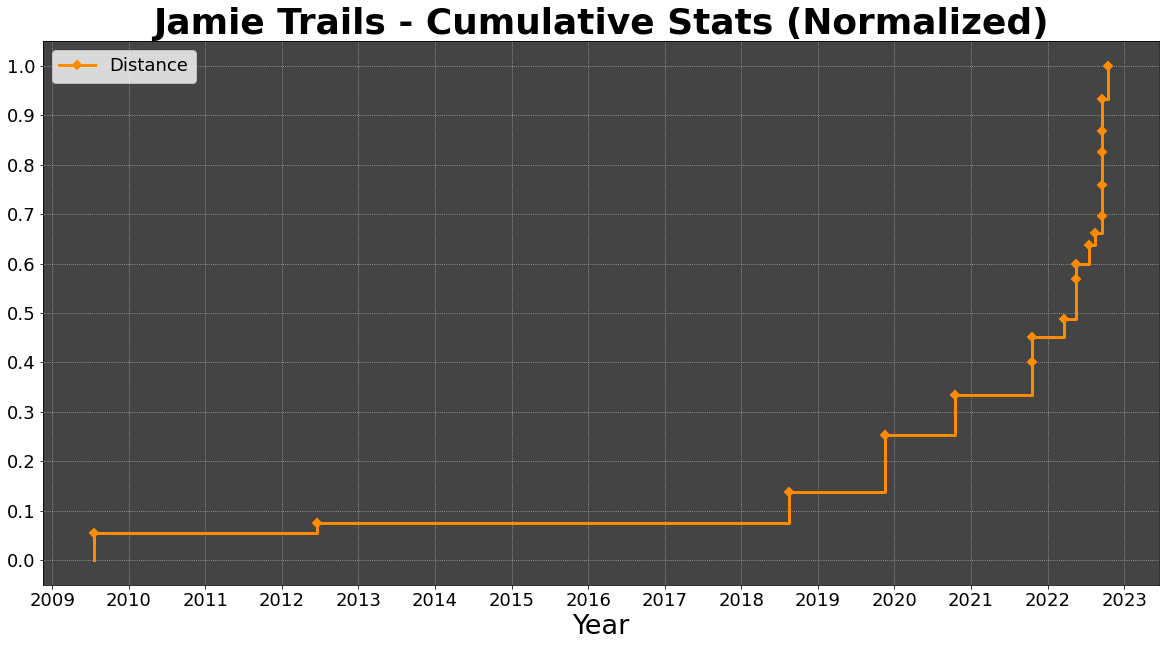

<Figure size 432x288 with 0 Axes>

In [10]:
### Jamie Trails - Cumulative Stats

def monthToYears(month):
    return months.index(month)/12 + 1/24

# To be filled one hike at a time
cumulativeDist = []
cumulativeGain = []
cumulativeDays = []
cumulativeHikes = []
years = []

# Cumulation
for i, hike in myCompletedTrails.iterrows():
    if i == 0:
        # Adding a dummy point for step plot appearance
        cumulativeDist.append(0)
        cumulativeGain.append(0)
        cumulativeDays.append(0)
        cumulativeHikes.append(0)
        years.append(hike.year + monthToYears(hike.month))

    cumulativeDist.append(cumulativeDist[i] + hike.len)
    cumulativeGain.append(cumulativeGain[i] + hike.gain)
    cumulativeDays.append(cumulativeDays[i] + hike.days)
    cumulativeHikes.append(cumulativeHikes[i] + 1.0)
    years.append(hike.year + monthToYears(hike.month))

# Plotting
ax = plt.gca()
fig = plt.gcf()
ax.set_title("Jamie Trails - Cumulative Stats (Normalized)", size=titleSize, fontweight="bold")
plt.step(years, cumulativeDist/np.max(cumulativeDist), label="Distance", where="post", linewidth=3,
         marker="D", mew=2, color=distColor, markevery=list(range(1,myCompletedTrails.shape[0]+1)))
# plt.step(years, cumulativeGain/np.max(cumulativeGain), label="Elevation Gain", where="post", linewidth=3,
#          marker="D", mew=2, color=gainColor, markevery=list(range(1,myCompletedTrails.shape[0]+1)))
# plt.step(years, cumulativeDays/np.max(cumulativeDays), label="Number of Days", where="post", linewidth=3,
#          marker="D", mew=2, color=daysColor, markevery=list(range(1,myCompletedTrails.shape[0]+1)))
# plt.step(years, cumulativeHikes/np.max(cumulativeHikes), label="Number of Hikes", where="post", linewidth=3,
#          marker="D", mew=2, color=hikesColor, markevery=list(range(1,len(cumulativeHikes))))
fig.set_size_inches(standardCanvasWidth, standardCanvasHeight)
plt.rcParams['axes.facecolor'] = backgroundColor
plt.grid(axis="both", which="both", linestyle= 'dotted')
ax.tick_params(axis='both', which='both', labelsize=tickLabelSize)
plt.legend(facecolor=legendColor, prop={'size': legendTextSize})
plt.locator_params(axis='y', nbins=11)
plt.xlabel("Year", size=axisLabelSize)
plt.xticks(ticks=range(int(myCompletedTrails.year.min()), int(myCompletedTrails.year.max()) + 2))
plt.show()
plt.clf()

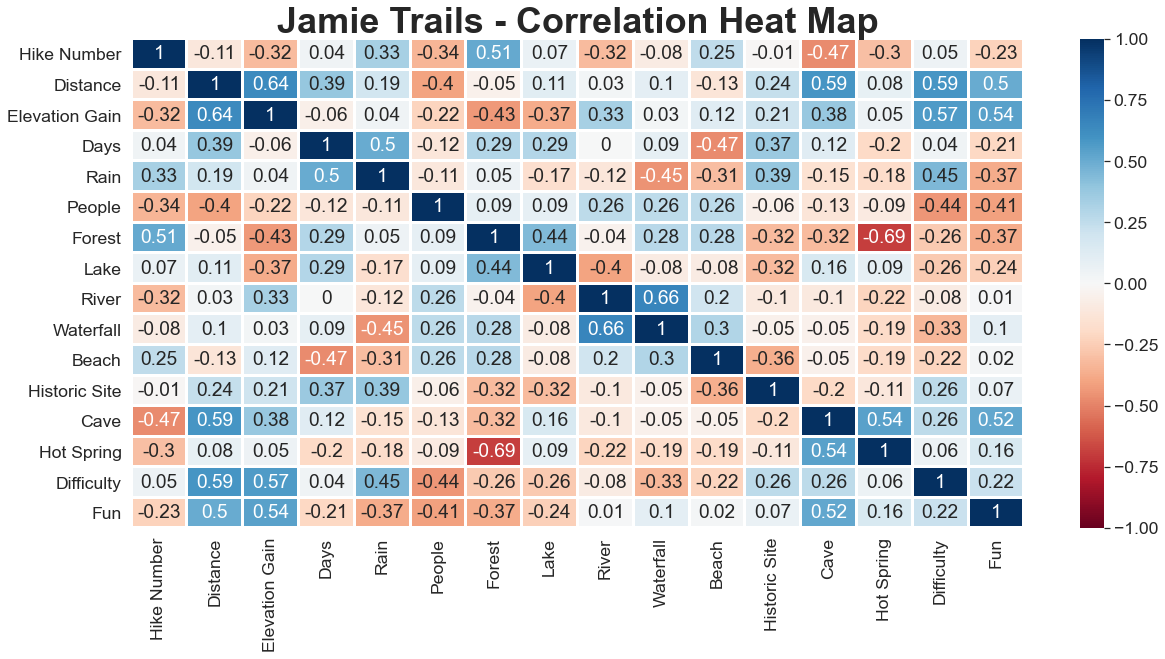

<function matplotlib.pyplot.clf()>

In [11]:
### Jamie Trails - Correlation Heat Map

myCompletedTrailsCorr = myCompletedTrails.drop(['lat','lng','year'],axis=1) # Removing unintersting cols
corr = myCompletedTrailsCorr.corr().round(2)
labels=['Hike Number','Distance','Elevation Gain','Days', 'Rain', 'People','Forest',
        'Lake','River','Waterfall','Beach','Historic Site','Cave','Hot Spring','Difficulty','Fun']
sns.set(rc={"figure.figsize":(standardCanvasWidth, standardCanvasHeight*0.9)})
sns.set(font_scale=1.6)

heatmap = sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center= 0, cmap="RdBu",
                      linewidths=2, xticklabels=labels, yticklabels=labels)
ax = plt.gca()
ax.set_title("Jamie Trails - Correlation Heat Map", size=titleSize, fontweight="bold")
plt.show()
plt.clf

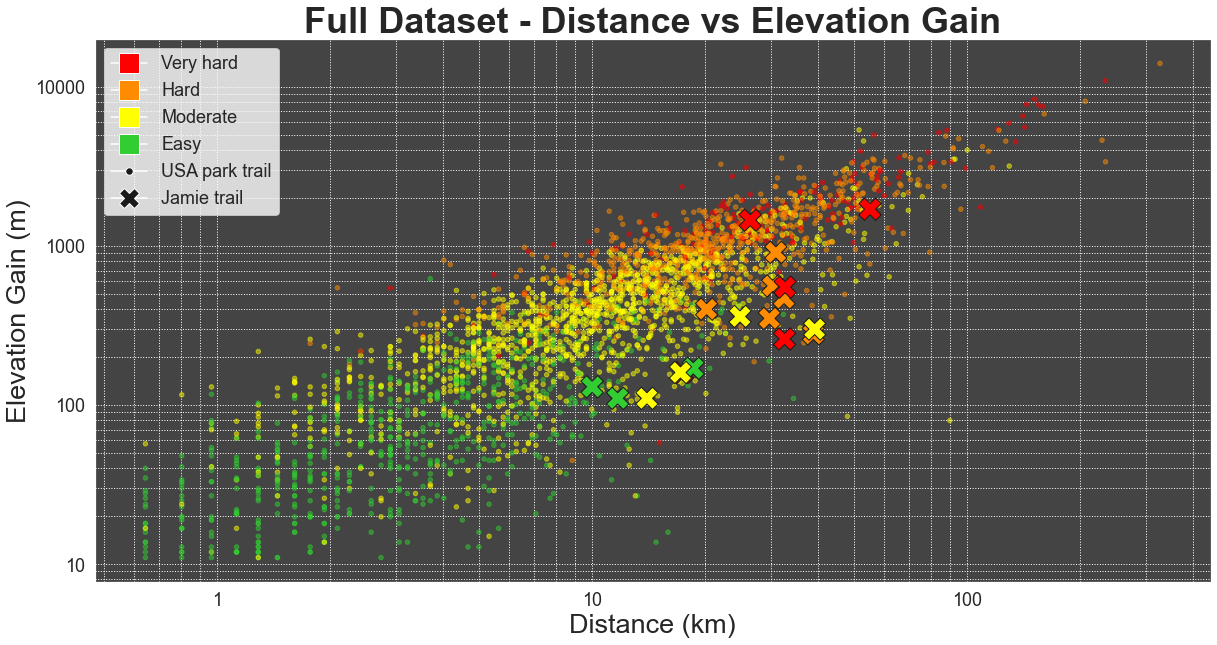

<Figure size 1440x648 with 0 Axes>

In [13]:
### Full Dataset - Distance vs Elevation Gain (with Difficulty, and Rating)

usaDist = usaTrails.len
usaGain = usaTrails.gain
usaDifficulty = difficultyColourIndex(usaTrails)

myDist = myCompletedTrailsForModel.len
myGain = myCompletedTrailsForModel.gain
myDifficulty = difficultyColourIndex(myCompletedTrailsForModel)

# Plotting
fig = plt.gcf()
ax = plt.gca()
ax.set_title("Full Dataset - Distance vs Elevation Gain", size=titleSize, fontweight='bold')
legend_elements = [
    Line2D([0], [0], marker='s', color=legendColor, label="Very hard", markerfacecolor=difficultyColors[3], markersize=20),
    Line2D([0], [0], marker='s', color=legendColor, label="Hard", markerfacecolor=difficultyColors[2], markersize=20),
    Line2D([0], [0], marker='s', color=legendColor, label="Moderate", markerfacecolor=difficultyColors[1], markersize=20),
    Line2D([0], [0], marker='s', color=legendColor, label="Easy", markerfacecolor=difficultyColors[0], markersize=20),
    Line2D([0], [0], marker='.', color=legendColor, label="USA park trail", markerfacecolor='k', markersize=15),
    Line2D([0], [0], marker='X', color=legendColor, label="Jamie trail", markerfacecolor='k', markersize=20)]
ax.legend(handles=legend_elements, facecolor=legendColor, prop={'size': legendTextSize})
plt.scatter(usaDist, usaGain, s=20, c=difficultyColors[usaDifficulty], marker='o', alpha=0.5)
plt.scatter(myDist, myGain, s=500, c=difficultyColors[myDifficulty], marker='X', edgecolors='k')
fig.set_size_inches(standardCanvasWidth, standardCanvasHeight)
plt.rcParams['axes.facecolor'] = backgroundColor
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel("Distance (km)", size=axisLabelSize)
plt.ylabel("Elevation Gain (m)", size=axisLabelSize)
plt.grid(axis="both", which="both", linestyle= 'dotted')
ax.tick_params(axis='both', which='both', labelsize=tickLabelSize)
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
plt.show()
plt.clf()  

In [14]:
### Full Dataset - Trail Locations

fig = go.Figure(data=go.Scattergeo(lon = ourTrails['lng'],
                                   lat = ourTrails['lat'],
                                   text = ourTrails['province'],
                                   mode = 'markers',
                                   marker_color = 'purple',
                                   marker = dict(
                                       size = 10,
                                       opacity = 0.2,
                                       symbol = 'x-open'
                                   )))
fig.update_layout(
    title = 'Full Dataset - Trail Locations',
        geo = dict(
            scope='usa',projection_type='albers usa',
            showland = True,
            landcolor = "lightgrey",
            subunitcolor = "white",
            subunitwidth = 2
        ),
    )
fig.show()

<b><font size="3">--- Generating Difficulty Model and Predictions ---</font></b>

In [16]:
### Finding best DIFFICULTY estimator

y_difficulty = ourTrails.loc[:, 'difficulty']
ourTrailsDifficulty = ourTrails.drop(['name','rating', 'difficulty'], axis=1);
ourTrailsDifficulty_t = transformer.fit_transform(ourTrailsDifficulty)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(ourTrailsDifficulty_t, y_difficulty, test_size=0.2)

print('MODEL SCORES FOR DIFFICULTY:') # Can treat DIFFICULTY as numeric or catagorical
model = Ridge(alpha=1.0)
model.fit(X_train_d, y_train_d)
print(f'Ridge: {round(model.score(X_test_d, y_test_d), 2)}')
model = SVR(kernel="rbf")
model.fit(X_train_d, y_train_d)
print(f'SVR(kernel="rbf"): {round(model.score(X_test_d, y_test_d), 2)}')
model = Lasso(alpha=0.1)
model.fit(X_train_d, y_train_d)
print(f'Lasso: {round(model.score(X_test_d, y_test_d), 2)}')
model = make_pipeline(StandardScaler(with_mean=False), SVC(gamma='auto'))
model.fit(X_train_d, y_train_d)
print(f'Linear SVC: {round(model.score(X_test_d, y_test_d), 2)}')
model = RandomForestClassifier()
model.fit(X_train_d, y_train_d)
print(f'Random Forest Classifier: {round(model.score(X_test_d, y_test_d), 2)}')

MODEL SCORES FOR DIFFICULTY:
Ridge: 0.37
SVR(kernel="rbf"): 0.5
Lasso: 0.38
Linear SVC: 0.58
Random Forest Classifier: 0.7


In [18]:
### Creating DIFFICULTY model

difficutyModel = RandomForestClassifier()
difficutyModel = RandomizedSearchCV(estimator=difficutyModel, param_distributions=cvGrid, n_iter=81, cv=5, verbose=10)
difficutyModel.fit(X_train_d, y_train_d)
print(f'Difficulty Model Score: {round(difficutyModel.score(X_test_d, y_test_d), 3)}')
pickle.dump(difficutyModel, open(diffModelFileName, 'wb'))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5; 1/81] START max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/5; 1/81] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.556 total time=   0.5s
[CV 2/5; 1/81] START max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 2/5; 1/81] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.620 total time=   0.3s
[CV 3/5; 1/81] START max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 3/5; 1/81] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.575 total time=   0.3s
[CV 4/5; 1/81] START max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 4/5; 1/81] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.614 total time=   0.3s
[CV 5/5; 1/81] START max_depth=5, min_samples_leaf=1, min_samples_split=2, n_e

[CV 4/5; 8/81] END max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=250;, score=0.603 total time=   0.7s
[CV 5/5; 8/81] START max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=250
[CV 5/5; 8/81] END max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=250;, score=0.604 total time=   0.7s
[CV 1/5; 9/81] START max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=500
[CV 1/5; 9/81] END max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=500;, score=0.594 total time=   1.4s
[CV 2/5; 9/81] START max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=500
[CV 2/5; 9/81] END max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=500;, score=0.609 total time=   1.4s
[CV 3/5; 9/81] START max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=500
[CV 3/5; 9/81] END max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=500;, score=0.597 total time=   1.4s
[CV 4/5; 9/81] ST

[CV 2/5; 16/81] END max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=100;, score=0.584 total time=   0.3s
[CV 3/5; 16/81] START max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=100
[CV 3/5; 16/81] END max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=100;, score=0.586 total time=   0.3s
[CV 4/5; 16/81] START max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=100
[CV 4/5; 16/81] END max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=100;, score=0.590 total time=   0.3s
[CV 5/5; 16/81] START max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=100
[CV 5/5; 16/81] END max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=100;, score=0.617 total time=   0.3s
[CV 1/5; 17/81] START max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=250
[CV 1/5; 17/81] END max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=250;, score=0.584 total time=   0.7s
[CV 2/5;

[CV 5/5; 23/81] END max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=250;, score=0.613 total time=   0.8s
[CV 1/5; 24/81] START max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=500
[CV 1/5; 24/81] END max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=500;, score=0.584 total time=   1.6s
[CV 2/5; 24/81] START max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=500
[CV 2/5; 24/81] END max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=500;, score=0.612 total time=   1.4s
[CV 3/5; 24/81] START max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=500
[CV 3/5; 24/81] END max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=500;, score=0.590 total time=   2.1s
[CV 4/5; 24/81] START max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=500
[CV 4/5; 24/81] END max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=500;, score=0.599 total time=   2.0s
[CV 5/5;

[CV 3/5; 31/81] END max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.620 total time=   0.4s
[CV 4/5; 31/81] START max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 4/5; 31/81] END max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.639 total time=   0.4s
[CV 5/5; 31/81] START max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 5/5; 31/81] END max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.639 total time=   0.5s
[CV 1/5; 32/81] START max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=250
[CV 1/5; 32/81] END max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=250;, score=0.652 total time=   1.1s
[CV 2/5; 32/81] START max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=250
[CV 2/5; 32/81] END max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=250;, score=0.657 total time=   1.1s

[CV 1/5; 39/81] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=0.639 total time=   2.2s
[CV 2/5; 39/81] START max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=500
[CV 2/5; 39/81] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=0.655 total time=   2.3s
[CV 3/5; 39/81] START max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=500
[CV 3/5; 39/81] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=0.633 total time=   2.3s
[CV 4/5; 39/81] START max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=500
[CV 4/5; 39/81] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=0.642 total time=   2.2s
[CV 5/5; 39/81] START max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=500
[CV 5/5; 39/81] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=0.634 total time=   2.2s

[CV 4/5; 46/81] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.631 total time=   0.4s
[CV 5/5; 46/81] START max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 5/5; 46/81] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.632 total time=   0.4s
[CV 1/5; 47/81] START max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=250
[CV 1/5; 47/81] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=250;, score=0.622 total time=   1.0s
[CV 2/5; 47/81] START max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=250
[CV 2/5; 47/81] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=250;, score=0.646 total time=   1.0s
[CV 3/5; 47/81] START max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=250
[CV 3/5; 47/81] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=250;, score=0.627 total time=   0.9s

[CV 2/5; 54/81] END max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=500;, score=0.648 total time=   2.1s
[CV 3/5; 54/81] START max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=500
[CV 3/5; 54/81] END max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=500;, score=0.622 total time=   2.3s
[CV 4/5; 54/81] START max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=500
[CV 4/5; 54/81] END max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=500;, score=0.637 total time=   2.1s
[CV 5/5; 54/81] START max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=500
[CV 5/5; 54/81] END max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=500;, score=0.630 total time=   2.3s
[CV 1/5; 55/81] START max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/5; 55/81] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.646 total time=   0.8s

[CV 5/5; 61/81] END max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=0.641 total time=   0.6s
[CV 1/5; 62/81] START max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=250
[CV 1/5; 62/81] END max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=250;, score=0.650 total time=   1.5s
[CV 2/5; 62/81] START max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=250
[CV 2/5; 62/81] END max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=250;, score=0.663 total time=   1.6s
[CV 3/5; 62/81] START max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=250
[CV 3/5; 62/81] END max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=250;, score=0.670 total time=   1.6s
[CV 4/5; 62/81] START max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=250
[CV 4/5; 62/81] END max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=250;, score=0.655 total time=   1.6s

[CV 3/5; 69/81] END max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=500;, score=0.661 total time=   3.1s
[CV 4/5; 69/81] START max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=500
[CV 4/5; 69/81] END max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=500;, score=0.650 total time=   3.0s
[CV 5/5; 69/81] START max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=500
[CV 5/5; 69/81] END max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=500;, score=0.624 total time=   2.9s
[CV 1/5; 70/81] START max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=100
[CV 1/5; 70/81] END max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=100;, score=0.665 total time=   0.5s
[CV 2/5; 70/81] START max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=100
[CV 2/5; 70/81] END max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=100;, score=0.676 total time=   0.5s

[CV 1/5; 77/81] END max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=250;, score=0.646 total time=   1.2s
[CV 2/5; 77/81] START max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=250
[CV 2/5; 77/81] END max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=250;, score=0.661 total time=   1.3s
[CV 3/5; 77/81] START max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=250
[CV 3/5; 77/81] END max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=250;, score=0.642 total time=   1.3s
[CV 4/5; 77/81] START max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=250
[CV 4/5; 77/81] END max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=250;, score=0.650 total time=   1.2s
[CV 5/5; 77/81] START max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=250
[CV 5/5; 77/81] END max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=250;, score=0.632 total time=   1.4s

In [19]:
### Making DIFFICULTY predictions

difficutyModel = pickle.load(open(diffModelFileName, 'rb'))

myWatchedTrailsForModelFormatted = myWatchedTrailsForModel.drop(['name','rating', 'difficulty'], axis=1);
myWatchedTrailsForModelFormatted_t = transformer.fit_transform(myWatchedTrailsForModelFormatted)

print('Difficulty Predictions:')
for result in difficutyModel.predict(myWatchedTrailsForModelFormatted_t):
    print(result) # Print is in loop for a nice copyable result
print('\n')

difficutyModel_pp = difficutyModel.predict_proba(myWatchedTrailsForModelFormatted_t)
print('Weighted Average Difficulty Predictions:')
for i, row in enumerate(difficutyModel_pp):
    print(round((row[0])+(3*row[1])+(5*row[2])+(7*row[3]), 2))  # Print is in loop for a nice copyable result

Difficulty Predictions:
5.0
5.0
5.0
5.0
3.0
5.0
5.0
3.0
3.0
3.0
5.0
3.0
3.0
1.0
3.0
1.0
1.0
7.0
5.0
5.0
5.0
5.0
3.0


Weighted Average Difficulty Predictions:
4.85
4.39
4.79
4.62
3.71
5.03
4.82
3.95
3.75
3.81
4.25
3.71
3.73
2.92
2.84
2.68
2.38
5.13
5.22
4.95
4.94
4.21
4.27


<b><font size="3">--- Generating Fun Model and Predictions ---</font></b>

In [20]:
### Finding best RATING estimator

y_rating = ourTrails.loc[:, 'rating']
ourTrailsRating = ourTrails.drop(['name','rating', 'difficulty'], axis=1);

ourTrailsRating_t = transformer.fit_transform(ourTrailsRating)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(ourTrailsRating_t, y_rating, test_size=0.2)

print('MODEL SCORES FOR FUN:')
model = RidgeCV()
model.fit(X_train_r, y_train_r)
print(f'Ridge: {round(model.score(X_test_r, y_test_r), 2)}')
model = SVR(kernel="rbf")
model.fit(X_train_r, y_train_r)
print(f'SVR(kernel="rbf"): {round(model.score(X_test_r, y_test_r), 2)}')
model = Lasso(alpha=0.1)
model.fit(X_train_r, y_train_r)
print(f'Lasso: {round(model.score(X_test_r, y_test_r), 2)}')

MODEL SCORES FOR FUN:
Ridge: 0.19
SVR(kernel="rbf"): 0.15
Lasso: 0.12


In [21]:
### Creating RATING model
    
ratingModel = RidgeCV()
ratingModel.fit(X_train_r, y_train_r)
print(f'Fun Model Score: {round(ratingModel.score(X_test_r, y_test_r),3)}')
pickle.dump(model, open(ratingModelFileName, 'wb'))

Fun Model Score: 0.189


In [22]:
### Making RATING predictions

ratingModel = pickle.load(open(ratingModelFileName, 'rb'))

print('Fun Predictions:')
for result in ratingModel.predict(myWatchedTrailsForModelFormatted_t):
    print(round(result,2)) # Print is in loop for a nice copyable result

Fun Predictions:
4.35
4.16
4.25
4.21
4.18
4.35
4.42
4.18
4.22
4.18
4.27
4.19
4.21
4.19
4.19
4.19
4.18
4.46
4.4
4.22
4.24
4.27
4.23


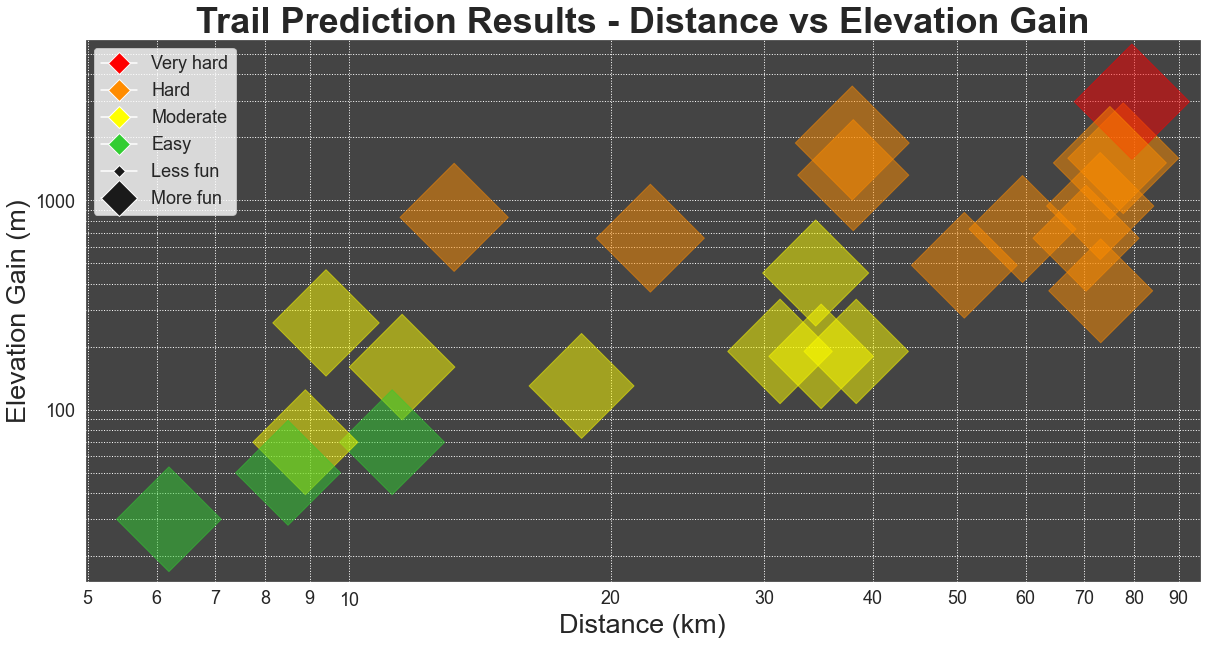

<Figure size 1440x648 with 0 Axes>

In [23]:
### Trail Prediction Results - Distance vs Elevation Gain (with Difficulty, and Rating)

distWatched = myWatchedTrails.len
gainWatched = myWatchedTrails.gain

ratingWatched = ratingSize(ratingModel.predict(myWatchedTrailsForModelFormatted_t))

diffWatched = []
for hikeDifficulty in difficutyModel.predict(myWatchedTrailsForModelFormatted_t):
    if hikeDifficulty == 1:
        diffWatched.append(0)
    elif hikeDifficulty == 3:
        diffWatched.append(1)
    elif hikeDifficulty == 5:
        diffWatched.append(2)
    elif hikeDifficulty == 7:
        diffWatched.append(3)

distGainPlot('Trail Prediction Results - Distance vs Elevation Gain', distWatched, gainWatched, ratingWatched, diffWatched)